# Homework 4 - MNIST Math 


# 2.1 Preparing MNIST Math Dataset

In [1]:
# load packages
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import datetime

# load dataset
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised = True, with_info = True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# 2.2 Two MNIST Math Datasets


In [2]:
def zip_ds(data, subtask, batch_size):

  #STEP 1: preprocessing

  #change datatype from uint8 to tf.float values
  ds = data.map(lambda img, target: (tf.cast(img, tf.float32), target))

  #flatten images through reshape function
  #-1 flattens to 1 dimensions and inferst the size
  ds = ds.map(lambda img, target: (tf.reshape(img, (-1,)), target))

  #normalize image values
  ds = ds.map(lambda img, target: ((img/128.)-1., target))

  #STEP 2: figuring out the parameterized targets

  # we want to have two mnist images in each example
  # this leads to a single example being ((x1,y1),(x2,y2))
  zipped_ds = tf.data.Dataset.zip((ds.shuffle(2000), 
                                  ds.shuffle(2000)))
  # map ((x1,y1),(x2,y2)) to (x1,x2, y1==y2*) *boolean
  if subtask == 1:
    zipped_ds = zipped_ds.map(lambda x1, x2: (x1[0], x2[0], (x1[1]+x2[1])>=5))
    # transform boolean target to int
    zipped_ds = zipped_ds.map(lambda x1, x2, t: (x1,x2, tf.cast(t, tf.int32)))
  elif subtask == 2:
   zipped_ds = zipped_ds.map(lambda x1, x2: (x1[0], x2[0], x1[1]-x2[1]))
   #encode as one-hot
   zipped_ds = zipped_ds.map(lambda x1, x2, t: (x1, x2, tf.one_hot(t, depth=20)))



  #STEP 3: shuffle and batch

  #shuffle again
  zipped_ds = zipped_ds.shuffle(2000)

  # batch the dataset
  zipped_ds = zipped_ds.batch(batch_size)
    

  return zipped_ds

train_ds_sub1 = zip_ds(train_ds, 1, 32)
#test_ds_sub1 = zip_ds(test_ds, 1, 32)

#train_ds_sub2 = zip_ds(train_ds, 2, 32)
#test_ds_sub2 = zip_ds(test_ds, 2, 32)

In [ ]:
# check the contents of the dataset
for img1, img2, target in train_ds_sub1.take(1):
  print(img1.shape, img2.shape, target)


(32, 784) (32, 784) tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1], shape=(32,), dtype=int32)


# 3. Building shared weight models

In [3]:
class SharedWeightModel(tf.keras.Model):

    # 1. constructor
    def __init__(self, subtask, optimizer):
        super().__init__()
        # inherit functionality from parent class

        # optimizer, loss function and metrics
        if subtask == 1:
          self.metrics_list = [tf.keras.metrics.BinaryAccuracy(),
                             tf.keras.metrics.Mean(name="loss")]
        elif subtask == 2:
          self.metrics_list = [tf.keras.metrics.CategoricalAccuracy(),
                             tf.keras.metrics.Mean(name="loss")]
        
        # choose the intended optimizer
        if optimizer == "Adam":
          self.optimizer = tf.keras.optimizers.Adam()
        elif optimizer == "SGD+":
          self.optimizer = tf.keras.optimizers.experimental.SGD(momentum = 0.9)
        elif optimizer == "SGD":
          self.optimizer = tf.keras.optimizers.experimental.SGD()
        elif optimizer == "RMS":
          self.optimizer = tf.keras.optimizers.experimental.RMSprop()
        elif optimizer == "AdaGrad":
          self.optimizer = tf.keras.optimizers.experimental.Adagrad()

        
        
        #different loss function for each subtask
        if subtask == 1:
          self.loss_function = tf.keras.losses.BinaryCrossentropy()
        elif subtask == 2:
          self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        
        # layers to be used
        self.dense1 = tf.keras.layers.Dense(32, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(32, activation=tf.nn.relu)
        
        if subtask == 1:
          #for subtask 1
          self.out_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
        elif subtask == 2:
          #for subtask 2
          self.out_layer = tf.keras.layers.Dense(20,activation=tf.nn.softmax)

        
        
        
        
    # 2. call method (forward computation)
    def call(self, images, training=False):
        img1, img2 = images
        
        img1_x = self.dense1(img1)
        img1_x = self.dense2(img1_x)
        
        img2_x = self.dense1(img2)
        img2_x = self.dense2(img2_x)
        
        combined_x = tf.concat([img1_x, img2_x ], axis=1)

        
        return self.out_layer(combined_x)



    # 3. metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model to collect accuracies



    # 4. reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()



    # 5. train step method
    def train_step(self, data): #add optimizer and which subtask to solve
        img1, img2, label = data
        
        with tf.GradientTape() as tape:
            output = self((img1, img2), training=True)
            loss = self.loss_function(label, output)
            
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name : m.result() for m in self.metrics}


    # 6. test_step method
    def test_step(self, data):
        img1, img2, label = data

        # same as train step (without parameter updates)
        output = self((img1, img2), training=True)
        loss = self.loss_function(label, output)

        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

In [4]:
def create_summary_writers(config_name):
    
    # Define where to save the logs
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/training"
    val_log_path = f"logs/{config_name}/{current_time}/test"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    return train_summary_writer, val_summary_writer



In [5]:
def training_function(subtask, optimizer):
  train_summary_writer, val_summary_writer = create_summary_writers(config_name = 'sub' + str(subtask) + str(optimizer))

  epochs = 10
  prep_train_ds = zip_ds(train_ds, subtask, 32)
  prep_test_ds = zip_ds(test_ds, subtask, 32)

  model = SharedWeightModel(subtask, optimizer)
  training_loop(model, prep_train_ds, prep_test_ds, epochs, train_summary_writer, val_summary_writer)
  #return train_losses, train_accuracies, test_losses, test_accuracies

#pass a model to it that is supposed to be trained
#def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path):
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, val_summary_writer):

  #1. iterate over epochs
  for e in range(epochs):
    print(f'Epoch: {str(e)}')

    #2. train steps on all batches in the traning dataset
    for data in train_ds:
      metrics = model.train_step(data)

    # 3. log and print training metrics
    with train_summary_writer.as_default():
      # for scalar metrics:
      for metric in model.metrics:
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

    #4. reset metrics object
    model.reset_metrics()

    #5. evaluate on valdation data
    for test_data in test_ds:
      metrics_test = model.test_step(test_data)

    # 6. log validation metrics

    with val_summary_writer.as_default():
      # for scalar metrics:
        for metric in model.metrics:
          tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    print([f"test_{key}: {value.numpy()}" for (key, value) in metrics_test.items()])
    
    print("\n")


# 5. Experiments

In [6]:
!rm -rf logs/
# Training for subtask 1

# Training with classic SGD optimizer (without momentum)
print("SGD, Task1: \n")
model_sgd_t1 = training_function(subtask = 1, optimizer = "SGD")

# training with Adam optimizer
print("Adam, Task1: \n")
model_adam_t1 = training_function(subtask = 1, optimizer = "Adam")

# Training with SGD optimizer with momentum
print("SGD + momentum, Task1: \n")
model_sgd_mom_t1 = training_function(subtask = 1, optimizer = "SGD+")

# Training with RSMProb
print("RSMProb, Task1: \n")
model_rmsprob_t1 = training_function(subtask = 1, optimizer = "RMS")

# Training with AdaGrad
print("AdaGrad, Task1: \n")
model_adagrad_t1 = training_function(subtask = 1, optimizer = "AdaGrad")

SGD, Task1: 

Epoch: 0
['train_binary_accuracy: 0.8901833295822144', 'train_loss: 0.26622119545936584']
['test_binary_accuracy: 0.9150999784469604', 'test_loss: 0.2047421634197235']


Epoch: 1
['train_binary_accuracy: 0.920799970626831', 'train_loss: 0.19372282922267914']
['test_binary_accuracy: 0.9351000189781189', 'test_loss: 0.16270498931407928']


Epoch: 2
['train_binary_accuracy: 0.9332000017166138', 'train_loss: 0.1648150533437729']
['test_binary_accuracy: 0.9401999711990356', 'test_loss: 0.1494591236114502']


Epoch: 3
['train_binary_accuracy: 0.9431856870651245', 'train_loss: 0.1459481567144394']
['test_binary_accuracy: 0.9458000063896179', 'test_loss: 0.136213019490242']


Epoch: 4
['train_binary_accuracy: 0.9484714269638062', 'train_loss: 0.1335603892803192']
['test_binary_accuracy: 0.9505000114440918', 'test_loss: 0.1329101175069809']


Epoch: 5
['train_binary_accuracy: 0.952571451663971', 'train_loss: 0.12748952209949493']
['test_binary_accuracy: 0.9549000263214111', 'test_

In [ ]:
#the line below removes all the collected values in the logs-folder for the individual trainings
#!rm -rf logs/

# open the tensorboard logs
%reload_ext tensorboard
%tensorboard --logdir logs/

In [7]:
!tensorboard dev upload --logdir ./logs\
  --name "Shared Weights Model with different optimizers"\
  --description "Training Results"\
  --one_shot

2022-11-28 08:19:39.463995: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoaut

In [8]:
# source: https://www.tensorflow.org/tensorboard/dataframe_api
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

# Loading TensorBoard scalars as a pandas.DataFrame
experiment_id = "KNt7hPpWSXCNgqZVAGHmjA"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

print(df["run"].unique())
print(df["tag"].unique())

['sub1AdaGrad/20221128-080510/test' 'sub1AdaGrad/20221128-080510/training'
 'sub1Adam/20221128-073258/test' 'sub1Adam/20221128-073258/training'
 'sub1RMS/20221128-075346/test' 'sub1RMS/20221128-075346/training'
 'sub1SGD+/20221128-074155/test' 'sub1SGD+/20221128-074155/training'
 'sub1SGD/20221128-072443/test' 'sub1SGD/20221128-072443/training']
['binary_accuracy' 'loss']


In [9]:
# Getting a pivoted (wide-form) DataFrame
dfw = experiment.get_scalars(pivot=True) 
dfw

,run,step,binary_accuracy,loss
0,sub1AdaGrad/20221128-080510/test,0,0.873700,0.296502
1,sub1AdaGrad/20221128-080510/test,1,0.894900,0.262976
2,sub1AdaGrad/20221128-080510/test,2,0.903700,0.248140
3,sub1AdaGrad/20221128-080510/test,3,0.904500,0.239751
4,sub1AdaGrad/20221128-080510/test,4,0.903500,0.244606
...,...,...,...,...
95,sub1SGD/20221128-072443/training,5,0.952571,0.127490
96,sub1SGD/20221128-072443/training,6,0.955257,0.119777
97,sub1SGD/20221128-072443/training,7,0.957786,0.114726
98,sub1SGD/20221128-072443/training,8,0.959357,0.112270


In [10]:
# Saving the DataFrame as CSV
csv_path = '/tmp/tb_experiment_subtask1.csv'
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

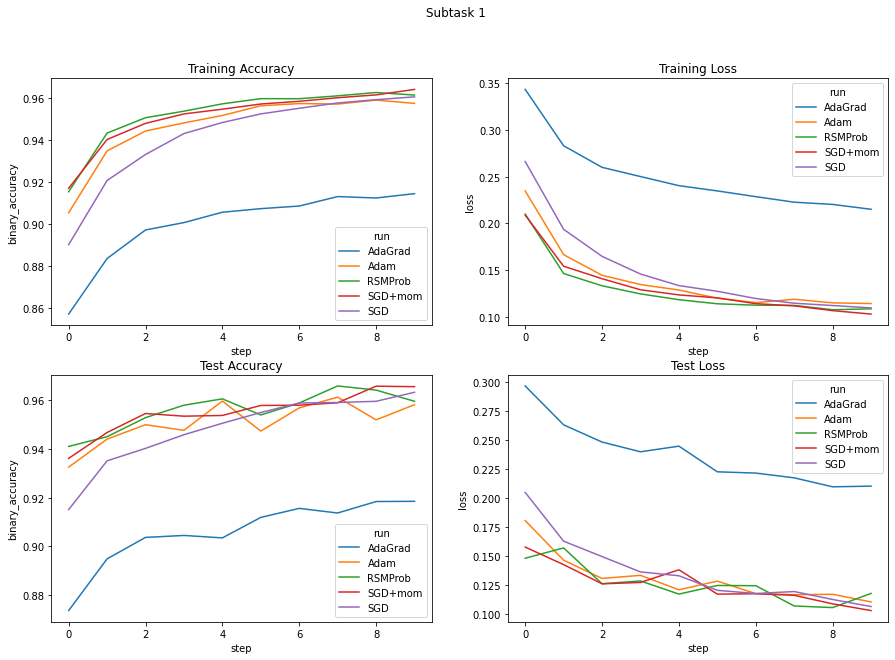

In [11]:
# Performing custom visualization and statistical analysis
# Filter the DataFrame to only validation data, which is what the subsequent
# analyses and visualization will be focused on.
dfw_training = dfw[dfw.run.str.endswith("/training")]
# Get the optimizer value for each row of the training DataFrame.
optimizer_training = dfw_training.run.apply(lambda run: run.split(",")[0])

dfw_test = dfw[dfw.run.str.endswith("/test")]
# Get the optimizer value for each row of the test DataFrame.
optimizer_test = dfw_test.run.apply(lambda run: run.split(",")[0])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Subtask 1')

sns.lineplot(ax=axes[0,0], data=dfw_training, x="step", y="binary_accuracy",
             hue=optimizer_training).set_title("Training Accuracy")
axes[0,0].legend(title='run', labels=['AdaGrad', 'Adam', 'RSMProb', 'SGD+mom', 'SGD'])

sns.lineplot(ax=axes[0,1], data=dfw_training, x="step", y="loss",
             hue=optimizer_training).set_title("Training Loss")
axes[0,1].legend(title='run', labels=['AdaGrad', 'Adam', 'RSMProb', 'SGD+mom', 'SGD'])

sns.lineplot(ax=axes[1,0], data=dfw_test, x="step", y="binary_accuracy",
             hue=optimizer_test).set_title("Test Accuracy")
axes[1,0].legend(title='run', labels=['AdaGrad', 'Adam', 'RSMProb', 'SGD+mom', 'SGD'])

sns.lineplot(ax=axes[1,1], data=dfw_test, x="step", y="loss",
             hue=optimizer_test).set_title("Test Loss")
axes[1,1].legend(title='run', labels=['AdaGrad', 'Adam', 'RSMProb', 'SGD+mom', 'SGD'])

Observations:
- The AdaGrad Optimizer has the highest losses in training and test step. Therefore its accuracies are also quite bad.
- In generel the Adam, RMSProb and SGD plus momentum optimizers perform the best. 
- SGD without momentum is nearly as good as the other three. It starts at a much lower accuracy but increases fast.

In [12]:
!rm -rf logs/
# Training for subtask 2

# Training with classic SGD optimizer (without momentum)
print("SGD, Task2: \n")
mode_sgd_t2 = training_function(subtask = 2, optimizer = "SGD")

# training with Adam optimizer
print("Adam, Task2: \n")
model_adam_t2 = training_function(subtask = 2, optimizer = "Adam")

# Training with SGD optimizer with momentum
print("SGD + momentum, Task2: \n")
mode_sgd_mom_t2 = training_function(subtask = 2, optimizer = "SGD+")

# Training with RSMProb
print("RSMProb, Task2: \n")
mode_rmsprob_t2 = training_function(subtask = 2, optimizer = "RMS")

# Training with AdaGrad
print("AdaGrad, Task2: \n")
mode_adagrad_t2 = training_function(subtask = 2, optimizer = "AdaGrad")

SGD, Task2: 

Epoch: 0
['train_categorical_accuracy: 0.38351666927337646', 'train_loss: 1.122879147529602']
['test_categorical_accuracy: 0.5120999813079834', 'test_loss: 1.0384150743484497']


Epoch: 1
['train_categorical_accuracy: 0.5003286004066467', 'train_loss: 1.0155748128890991']
['test_categorical_accuracy: 0.5849000215530396', 'test_loss: 0.9777597784996033']


Epoch: 2
['train_categorical_accuracy: 0.5463571548461914', 'train_loss: 0.9501696228981018']
['test_categorical_accuracy: 0.4731999933719635', 'test_loss: 0.9192495346069336']


Epoch: 3
['train_categorical_accuracy: 0.5724856853485107', 'train_loss: 0.9018957018852234']
['test_categorical_accuracy: 0.6055999994277954', 'test_loss: 0.8850366473197937']


Epoch: 4
['train_categorical_accuracy: 0.6117143034934998', 'train_loss: 0.8664411902427673']
['test_categorical_accuracy: 0.6371999979019165', 'test_loss: 0.850492537021637']


Epoch: 5
['train_categorical_accuracy: 0.6262000203132629', 'train_loss: 0.8420017957687378'

In [ ]:
#the line below removes all the collected values in the logs-folder for the individual trainings
#!rm -rf logs/

# open the tensorboard logs
%reload_ext tensorboard
%tensorboard --logdir logs/

In [13]:
!tensorboard dev upload --logdir ./logs\
  --name "Shared Weights Model with different optimizers"\
  --description "Training Results"\
  --one_shot

2022-11-28 09:15:33.676389: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/6gDrLxInQOKHPDu87R79NQ/

[2022-11-28T09:15:33] Started scanning logdir.
[2022-11-28T09:15:34] Total uploaded: 200 scalars, 0 tensors, 0 binary objects
[2022-11-28T09:15:34] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/6gDrLxInQOKHPDu87R79NQ/


In [14]:
# source: https://www.tensorflow.org/tensorboard/dataframe_api
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

# Loading TensorBoard scalars as a pandas.DataFrame
experiment_id = "6gDrLxInQOKHPDu87R79NQ"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

print(df["run"].unique())
print(df["tag"].unique())

['sub2AdaGrad/20221128-090258/test' 'sub2AdaGrad/20221128-090258/training'
 'sub2Adam/20221128-083129/test' 'sub2Adam/20221128-083129/training'
 'sub2RMS/20221128-085058/test' 'sub2RMS/20221128-085058/training'
 'sub2SGD+/20221128-083946/test' 'sub2SGD+/20221128-083946/training'
 'sub2SGD/20221128-082119/test' 'sub2SGD/20221128-082119/training']
['categorical_accuracy' 'loss']


In [15]:
# Getting a pivoted (wide-form) DataFrame
dfw = experiment.get_scalars(pivot=True) 
dfw

,run,step,categorical_accuracy,loss
0,sub2AdaGrad/20221128-090258/test,0,0.437400,1.177511
1,sub2AdaGrad/20221128-090258/test,1,0.408600,1.146629
2,sub2AdaGrad/20221128-090258/test,2,0.414800,1.128983
3,sub2AdaGrad/20221128-090258/test,3,0.452200,1.114101
4,sub2AdaGrad/20221128-090258/test,4,0.433000,1.120964
...,...,...,...,...
95,sub2SGD/20221128-082119/training,5,0.626200,0.842002
96,sub2SGD/20221128-082119/training,6,0.637843,0.818506
97,sub2SGD/20221128-082119/training,7,0.646714,0.800816
98,sub2SGD/20221128-082119/training,8,0.660057,0.786046


In [16]:
# Saving the DataFrame as CSV
csv_path = '/tmp/tb_experiment_subtask2.csv'
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

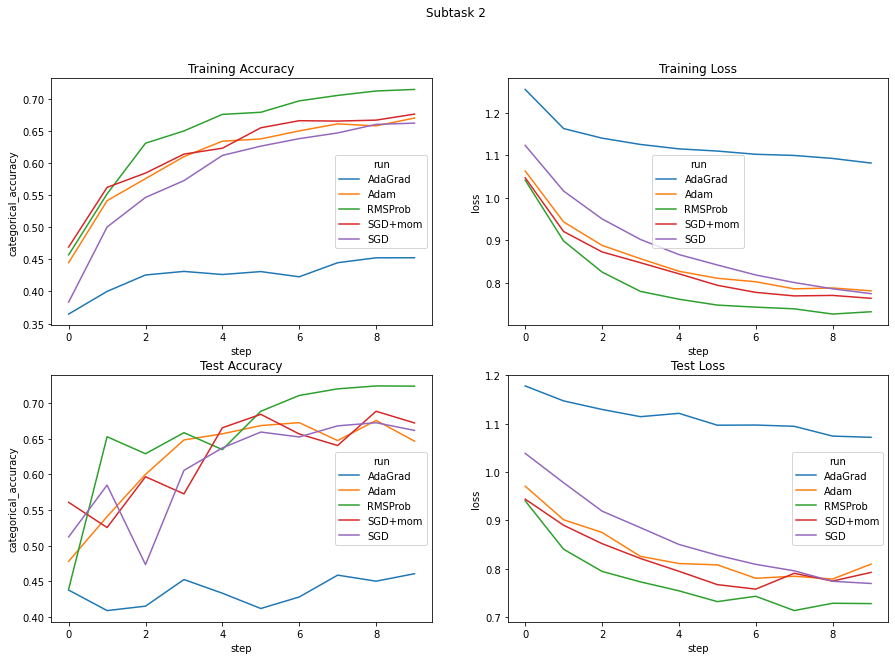

In [20]:
# Performing custom visualization and statistical analysis
# Filter the DataFrame to only validation data, which is what the subsequent
# analyses and visualization will be focused on.
dfw_training = dfw[dfw.run.str.endswith("/training")]
# Get the optimizer value for each row of the training DataFrame.
optimizer_training = dfw_training.run.apply(lambda run: run.split(",")[0])

dfw_test = dfw[dfw.run.str.endswith("/test")]
# Get the optimizer value for each row of the test DataFrame.
optimizer_test = dfw_test.run.apply(lambda run: run.split(",")[0])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Subtask 2')

sns.lineplot(ax=axes[0,0], data=dfw_training, x="step", y="categorical_accuracy",
             hue=optimizer_training).set_title("Training Accuracy")
axes[0,0].legend(title='run', labels=['AdaGrad', 'Adam', 'RMSProb', 'SGD+mom', 'SGD'])

sns.lineplot(ax=axes[0,1], data=dfw_training, x="step", y="loss",
             hue=optimizer_training).set_title("Training Loss")
axes[0,1].legend(title='run', labels=['AdaGrad', 'Adam', 'RMSProb', 'SGD+mom', 'SGD'])

sns.lineplot(ax=axes[1,0], data=dfw_test, x="step", y="categorical_accuracy",
             hue=optimizer_test).set_title("Test Accuracy")
axes[1,0].legend(title='run', labels=['AdaGrad', 'Adam', 'RMSProb', 'SGD+mom', 'SGD'])

sns.lineplot(ax=axes[1,1], data=dfw_test, x="step", y="loss",
             hue=optimizer_test).set_title("Test Loss")
axes[1,1].legend(title='run', labels=['AdaGrad', 'Adam', 'RMSProb', 'SGD+mom', 'SGD'])

Observations:
- The AdaGrad Optimizer has the highest losses in training and test step. Therefore its accuracies are also quite bad.
- In generel the Adam, RMSProb and SGD and SGD plus momentum optimizers perform the best. 
- SGD without momentum is nearly as good as the other three. It starts at a much lower accuracy but increases fast.
- RMSProb seems to be the most accurate optimizer increasing accuracies and decreasing losses very fast.

- In contrast to the model performing subtask 1, the model performing subtask 2 seems to be much more prone to error. Wild guess: Can be the case due to the fact that it's also possible to calculate negative outputs that are not encountered in the MNIST dataset.